In [2]:
import sys
sys.path.append('../..')

import json
import pandas as pd

import torch

In [4]:
df_x = pd.read_csv('../../data/gaia/raw/gaia_full_snc_mom_vel.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/gaia/raw/gaia_full_snc_mom_vel.csv'

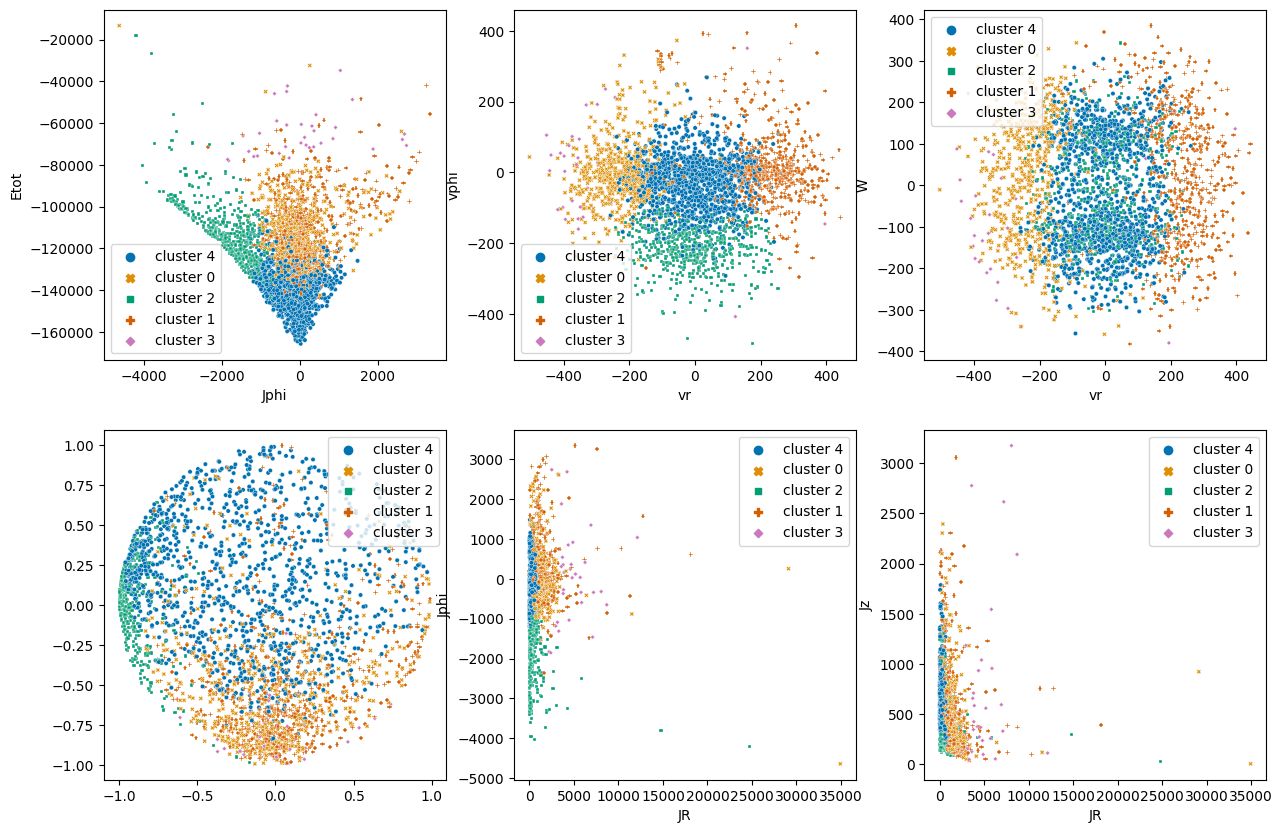

In [44]:
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15, 10))
axs = axs.flatten()
sns.scatterplot(data=df_x, x='Jphi', y='Etot', hue=clusters, style=clusters, s=10, ax=axs[0])
sns.scatterplot(data=df_x, x='vr', y='vphi', hue=clusters, style=clusters, s=10, ax=axs[1])
sns.scatterplot(data=df_x, x='vr', y='W', hue=clusters, style=clusters, s=10, ax=axs[2])
J = np.sqrt(X[:,3]**2 + X[:,2]**2 + X[:,1]**2)
sns.scatterplot(x=X[:,3]/J, y=(X[:,2]-X[:,1])/J, hue=clusters, style=clusters, s=10, ax=axs[3])
sns.scatterplot(data=df_x, x='JR', y='Jphi', hue=clusters, style=clusters, s=10, ax=axs[4])
sns.scatterplot(data=df_x, x='JR', y='Jz', hue=clusters, style=clusters, s=10, ax=axs[5])
fig.savefig('../../sample_snc.png')

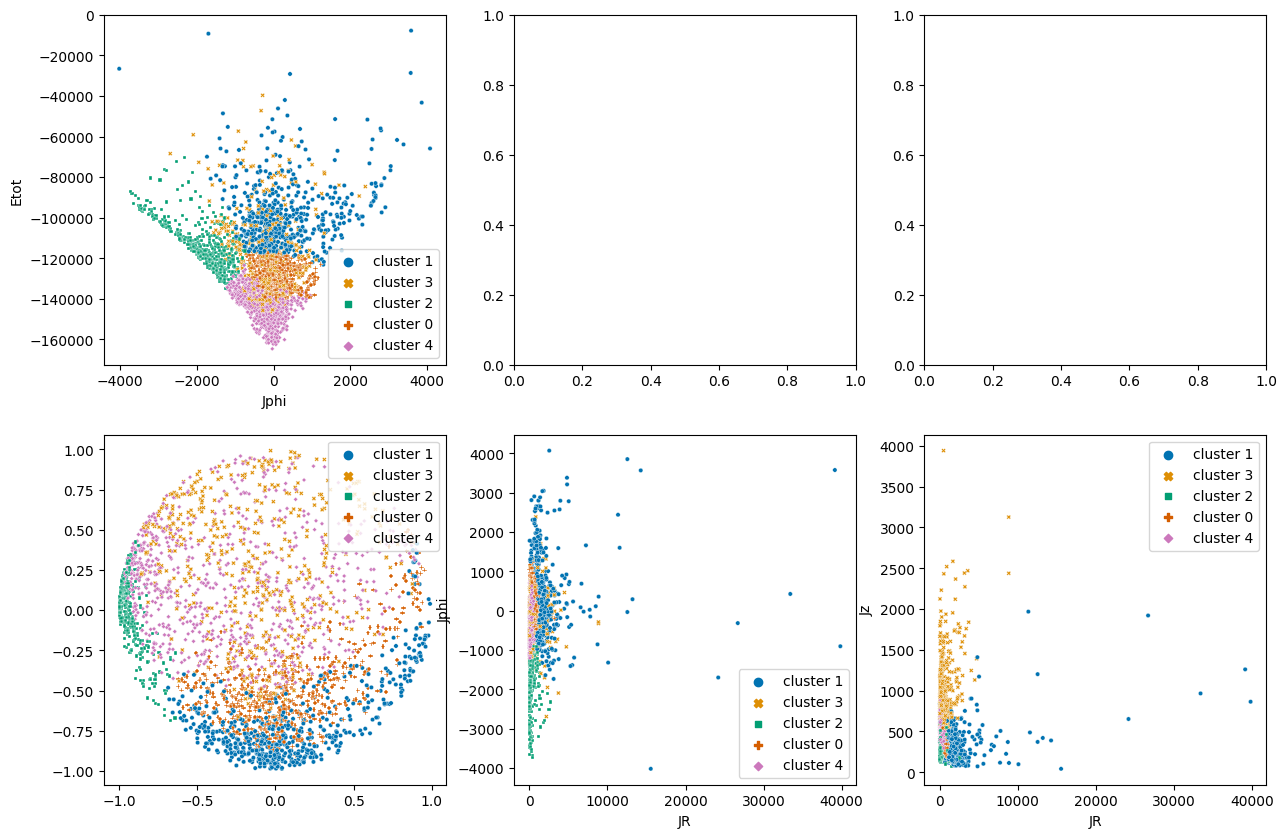

In [25]:
fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15, 10))
axs = axs.flatten()
sns.scatterplot(data=df_x, x='Jphi', y='Etot', hue=clusters, style=clusters, s=10, ax=axs[0])
J = np.sqrt(X[:,3]**2 + X[:,2]**2 + X[:,1]**2)
sns.scatterplot(x=X[:,3]/J, y=(X[:,2]-X[:,1])/J, hue=clusters, style=clusters, s=10, ax=axs[3])
sns.scatterplot(data=df_x, x='JR', y='Jphi', hue=clusters, style=clusters, s=10, ax=axs[4])
sns.scatterplot(data=df_x, x='JR', y='Jz', hue=clusters, style=clusters, s=10, ax=axs[5])
fig.savefig('../../sample_snc.png')

In [ ]:
sns.scatterplot(x=X[:,9], y=X[:,10], hue=clusters, style=clusters, s=10)

In [ ]:
J = np.sqrt(X[:,3]**2 + X[:,2]**2 + X[:,1]**2)
ax = sns.scatterplot(x=X[:,3]/J, y=(X[:,2]-X[:,1])/J, hue=clusters, style=clusters, s=10)

In [ ]:
ax = sns.scatterplot(x=X[:,1], y=X[:,2], hue=clusters, style=clusters, s=10)
ax.set(xlim=[0,20000])

In [ ]:
ax = sns.scatterplot(x=X[:,4], y=X[:,12], hue=clusters, style=clusters, s=10)

In [ ]:
POS = [X[:,4]*torch.cos(X[:,11]),X[:,4]*torch.sin(X[:,11]),X[:,12]]
ax = sns.scatterplot(x=POS[0], y=POS[1], hue=clusters, style=clusters, s=10)

In [ ]:
ax = sns.scatterplot(x=X[:,11], y=X[:,4], hue=clusters, style=clusters, s=10)